In [0]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

print(torch.__version__)
print(torch.cuda.is_available())

tcmalloc: large alloc 1073750016 bytes == 0x57818000 @  0x7f7911e3c2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
0.4.1
True


In [0]:
!pip install tensorboard

In [0]:
!pip install tensorboardX

    100% |████████████████████████████████| 133kB 3.7MB/s 


In [0]:
dataname="lymphoma"
gpuid=2

# --- densenet params
#these parameters get fed directly into the densenet class, and more description of them can be discovered there
n_classes= 3    #number of classes in the data mask that we'll aim to predict
in_channels= 3  #input channel of the data, RGB = 3


growth_rate=32 
block_config=(2, 2, 2, 2)
num_init_features=64
bn_size=4
drop_rate=0
num_classes=3


# --- training params
batch_size=128
patch_size=224 #currently, this needs to be 224 due to densenet architecture
num_epochs = 100
phases = ["train","val"] #how many phases did we create databases for?
validation_phases= ["val"] #when should we do valiation? note that validation is *very* time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch
                           #additionally, using simply [], will skip validation entirely, drastically speeding things up

In [0]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import DenseNet

import PIL
import matplotlib.pyplot as plt
import cv2

import numpy as np
import sys, glob

from tensorboardX import SummaryWriter

import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix

In [0]:
#helper function for pretty printing of current time and remaining time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
#specify if we should use a GPU (cuda) or only the CPU
cuda = torch.device('cuda')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda


In [0]:
#build the model according to the paramters specified above and copy it to the GPU. finally print out the number of trainable parameters
 
model = DenseNet(growth_rate=growth_rate, block_config=block_config,
                 num_init_features=num_init_features, bn_size=bn_size, drop_rate=drop_rate, num_classes=num_classes).to(device)
#model = DenseNet(growth_rate=32, block_config=(6, 12, 24, 16), #these represent the default parameters
#                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=3)

print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


total params: 	415683


In [0]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,img_transform=None):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname

        self.img_transform=img_transform
        
        with tables.open_file(self.fname,'r') as db:
            self.classsizes=db.root.classsizes[:]
            self.nitems=db.root.imgs.shape[0]
        
        self.imgs = None
        self.labels = None
        
    def __getitem__(self, index):
        #opening should be done in __init__ but seems to be
        #an issue with multithreading so doing here. need to do it everytime, otherwise hdf5 crashes

        with tables.open_file(self.fname,'r') as db:
            self.imgs=db.root.imgs
            self.labels=db.root.labels

            #get the requested image and mask from the pytable
            img = self.imgs[index,:,:,:]
            label = self.labels[index]
        
        
        img_new = img
        
        if self.img_transform is not None:
            img_new = self.img_transform(img)


        return img_new, label, img
    def __len__(self):
        return self.nitems

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
img_transform = transforms.Compose([
     transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), 
    transforms.RandomResizedCrop(size=patch_size),
    transforms.RandomRotation(180),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=.5),
    transforms.RandomGrayscale(),
    transforms.ToTensor()
    ])


dataset={}
dataLoader={}
for phase in phases: 
    
    dataset[phase]=Dataset("/content/gdrive/My Drive/lymphomaProject/dataname_phase.pytable", img_transform=img_transform)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0,pin_memory=True) 
    print(f"{phase} dataset size:\t{len(dataset[phase])}")

train dataset size:	10080
val dataset size:	10080


1


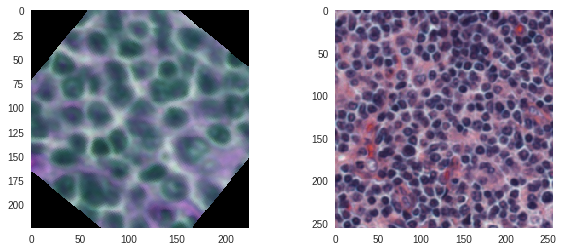

In [0]:
plt.rcParams["axes.grid"] = False
#visualize a single example to verify that it is correct
(img, label, img_old)=dataset["train"][7]
fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

#build output showing patch after augmentation and original patch
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(img_old)

print(label)

In [0]:
optim = torch.optim.Adam(model.parameters()) #adam is going to be the most robust, though perhaps not the best performing, typically a good place to start

In [0]:
#we have the ability to weight individual classes, in this case we'll do so based on their presense in the trainingset
#to avoid biasing any particular class
nclasses = dataset["train"].classsizes.shape[0]
class_weight=dataset["train"].classsizes
class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)

print(class_weight) #show final used weights, make sure that they're reasonable before continouing
criterion = nn.CrossEntropyLoss(weight = class_weight)

tensor([0.6994, 0.6250, 0.6756], device='cuda:0')


In [0]:
#def trainnetwork():
    writer=SummaryWriter() #open the tensorboard visualiser
    best_loss_on_test = np.Infinity

    start_time = time.time()
    for epoch in range(num_epochs):
        #zero out epoch based performance variables 
        all_acc = {key: 0 for key in phases} 
        all_loss = {key: torch.zeros(0).to(device) for key in phases} #keep this on GPU for greatly improved performance
        cmatrix = {key: np.zeros((n_classes,n_classes)) for key in phases}

        for phase in phases: #iterate through both training and validation states

            if phase == 'train':
                model.train()  # Set model to training mode
            else: #when in eval mode, we don't want parameters to be updated
                model.eval()   # Set model to evaluate mode

            for ii , (X, label, img_orig) in enumerate(dataLoader[phase]): #for each of the batches
                X = X.to(device)  # [Nbatch, 3, H, W]
                label = label.type('torch.LongTensor').to(device)  # [Nbatch, 1] with class indices (0, 1, 2,...n_classes)

                with torch.set_grad_enabled(phase == 'train'): #dynamically set gradient computation, in case of validation, this isn't needed
                                                                #disabling is good practice and improves inference time

                    prediction = model(X)  # [N, Nclass]
                    loss = criterion(prediction, label)


                    if phase=="train": #in case we're in train mode, need to do back propogation
                        optim.zero_grad()
                        loss.backward()
                        optim.step()
                        train_loss = loss


                    all_loss[phase]=torch.cat((all_loss[phase],loss.detach().view(1,-1)))

                    if phase in validation_phases: #if this phase is part of validation, compute confusion matrix
                        p=prediction.detach().cpu().numpy()
                        cpredflat=np.argmax(p,axis=1).flatten()
                        yflat=label.cpu().numpy().flatten()

                        cmatrix[phase]=cmatrix[phase]+confusion_matrix(yflat,cpredflat, labels=range(nclasses))

            all_acc[phase]=(cmatrix[phase]/cmatrix[phase].sum()).trace()
            all_loss[phase] = all_loss[phase].cpu().numpy().mean()

            #save metrics to tensorboard
            writer.add_scalar(f'{phase}/loss', all_loss[phase], epoch)
            if phase in validation_phases:
                writer.add_scalar(f'{phase}/acc', all_acc[phase], epoch)
                for r in range(nclasses):
                    for c in range(nclasses): #essentially write out confusion matrix
                        writer.add_scalar(f'{phase}/{r}{c}', cmatrix[phase][r][c],epoch)

        print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
                                                     epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")    

        #if current loss is the best we've seen, save model state with all variables
        #necessary for recreation
        if all_loss["val"] < best_loss_on_test:
            best_loss_on_test = all_loss["val"]
            print("  **")
            state = {'epoch': epoch + 1,
             'model_dict': model.state_dict(),
             'optim_dict': optim.state_dict(),
             'best_loss_on_test': all_loss,
             'n_classes': n_classes,
             'in_channels': in_channels,
             'growth_rate':growth_rate,
             'block_config':block_config,
             'num_init_features':num_init_features,
             'bn_size':bn_size,
             'drop_rate':drop_rate,
             'num_classes':num_classes}


            torch.save(state, f"{dataname}_densenet_best_model.pth")
        else:
            print("")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


11m 15s (- 1113m 51s) ([1/100] 1%), train loss: 0.8776 test loss: 0.8562  **
16m 9s (- 791m 0s) ([2/100] 2%), train loss: 0.8001 test loss: 0.8675
21m 2s (- 680m 0s) ([3/100] 3%), train loss: 0.7595 test loss: 0.8783
25m 55s (- 621m 59s) ([4/100] 4%), train loss: 0.6913 test loss: 0.7393  **
30m 48s (- 585m 5s) ([5/100] 5%), train loss: 0.6422 test loss: 0.7760
35m 39s (- 558m 36s) ([6/100] 6%), train loss: 0.6052 test loss: 0.7437
40m 31s (- 538m 19s) ([7/100] 7%), train loss: 0.5639 test loss: 0.6156  **
45m 23s (- 522m 0s) ([8/100] 8%), train loss: 0.5396 test loss: 0.6095  **
50m 16s (- 508m 15s) ([9/100] 9%), train loss: 0.5234 test loss: 0.6685
55m 9s (- 496m 22s) ([10/100] 10%), train loss: 0.5014 test loss: 0.7724
60m 1s (- 485m 38s) ([11/100] 11%), train loss: 0.4856 test loss: 0.9467
64m 53s (- 475m 48s) ([12/100] 12%), train loss: 0.4632 test loss: 0.7051
69m 44s (- 466m 43s) ([13/100] 13%), train loss: 0.4690 test loss: 0.6929
74m 37s (- 458m 20s) ([14/100] 14%), train loss

In [0]:
#load best model
checkpoint = torch.load(f"{dataname}_densenet_best_model.pth")
model.load_state_dict(checkpoint["model_dict"])

In [0]:
#grab a single image from validation set
(img, label, img_old)=dataset["val"][2]

In [0]:
#generate its output
#%%timeit
output=model(img[None,::].to(device))
output=output.detach().squeeze().cpu().numpy()
output.shape

(3,)

In [0]:
print(output)
print(f"True class:{label}")
print(f"Predicted class:{np.argmax(output)}")

[-2.9939635  4.7492757 -4.49375  ]
True class:1
Predicted class:1


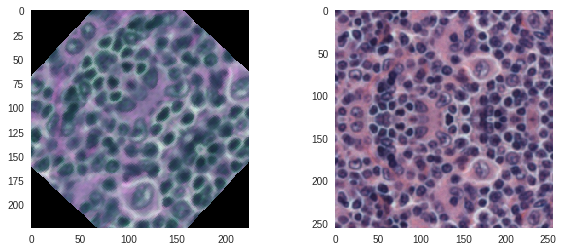

In [0]:
#look at input
fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(img_old)

In [0]:
#helper function for visualization
def plot_kernels(tensor, num_cols=8 ,cmap="gray"):
    if not len(tensor.shape)==4:
        raise Exception("assumes a 4D tensor")
#    if not tensor.shape[1]==3:
#        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0] * tensor.shape[1]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    i=0
    t=tensor.data.numpy()
    for t1 in t:
        for t2 in t1:
            i+=1
            ax1 = fig.add_subplot(num_rows,num_cols,i)
            ax1.imshow(t2 , cmap=cmap)
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [0]:
class LayerActivations():
    features=None
    def __init__(self,layer):
        self.hook = layer.register_forward_hook(self.hook_fn)
    def hook_fn(self,module,input,output):
        self.features = output.cpu()
    def remove(self):
        self.hook.remove()

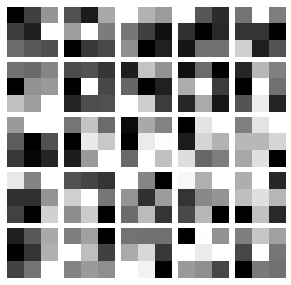

In [0]:
w=model.features.denseblock2.denselayer1.conv2
plot_kernels(w.weight.detach().cpu()[0:5,0:5,:,:],5)

In [0]:
#visualize activiations

In [0]:
dr=LayerActivations(model.features.denseblock2.denselayer1.conv2)

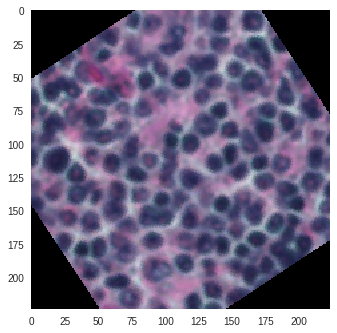

In [0]:
(img, label, img_old)=dataset["val"][7]
plt.imshow(np.moveaxis(img.numpy(),0,-1))
output=model(img[None,::].to(device))

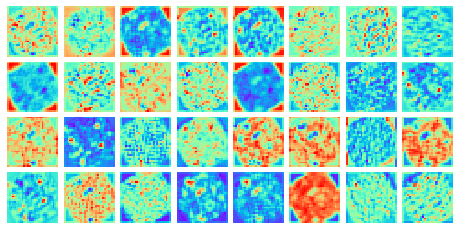

In [0]:
plot_kernels(dr.features,8,cmap="rainbow")

In [0]:
#load the model, note that the paramters are coming from the checkpoint, since the architecture of the model needs to exactly match the weights saved

model = DenseNet(growth_rate=checkpoint["growth_rate"], block_config=checkpoint["block_config"],
                 num_init_features=checkpoint["num_init_features"], bn_size=checkpoint["bn_size"], drop_rate=checkpoint["drop_rate"], num_classes=checkpoint["num_classes"]).to(device)

print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")
model.load_state_dict(checkpoint["model_dict"])

total params: 	415683


/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [0]:
patch_size=224 #should match the value used to train the network
batch_size=1 #nicer to have a single batch so that we can iterately view the output, while not consuming too much 
nprint = 2 # number of results to show

In [0]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,img_transform=None):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname

        self.img_transform=img_transform
        
        self.tables=tables.open_file(self.fname)
        self.classsizes=self.tables.root.classsizes[:]
        self.nitems=self.tables.root.imgs.shape[0]
        self.tables.close()
        
        self.imgs = None
        self.labels = None
        
    def __getitem__(self, index):
        #opening should be done in __init__ but seems to be
        #an issue with multithreading so doing here
        if(self.imgs is None): #open in thread
            self.tables=tables.open_file(self.fname)
            self.imgs=self.tables.root.imgs
            self.labels=self.tables.root.labels
       
        #get the requested image and mask from the pytable
        img = self.imgs[index,:,:,:]
        label = self.labels[index]
        
        img_new = img
        
        if self.img_transform is not None:
            img_new = self.img_transform(img)


        return img_new, label, img
    def __len__(self):
        return self.nitems

In [0]:
#probably only want to crop data to right size and otherwise not alter data during validation process
img_transform = transforms.Compose([
     transforms.ToPILImage(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), 
#     transforms.RandomResizedCrop(size=patch_size),
#     transforms.RandomRotation(180),
#     transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=.5),
#     transforms.RandomGrayscale(),
    transforms.ToTensor()
    ])

phases=["val"]
dataset={}
dataLoader={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    
    dataset[phase]=Dataset("/content/gdrive/My Drive/lymphomaProject/dataname_phase.pytable", img_transform=img_transform)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0, pin_memory=True)

[-2.1722405  3.8140295 -4.5015435]
True class:		1
Predicted class:	1
--------
[ 2.103369  -1.2376935 -4.1285906]
True class:		0
Predicted class:	0
--------
[  0.19251   -10.101178    4.9574404]
True class:		2
Predicted class:	2
--------
[ 4.9061313 -8.022026  -2.251845 ]
True class:		0
Predicted class:	0
--------
[[2. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Accuracty:	1.0


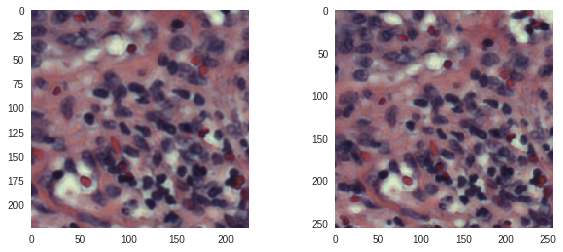

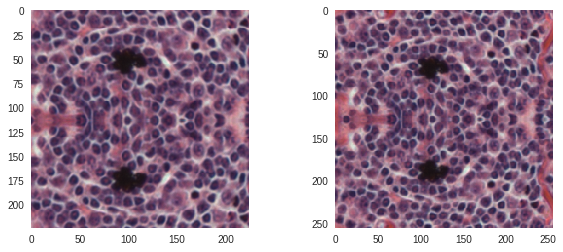

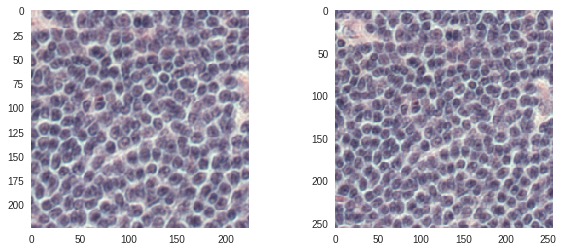

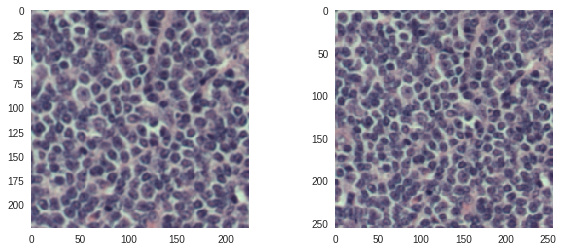

In [0]:
%matplotlib inline

#set the model to evaluation mode, since we're only generating output and not doing any back propogation
model.eval()
confmatrix=np.zeros((checkpoint["num_classes"],checkpoint["num_classes"]))
for ii , (X, label, img_orig) in enumerate(dataLoader['val']): #for each of the batches
    X = X.to(device)  # [NBATCH, 3, H, W]
    label = label.type('torch.LongTensor').to(device)  # [Nbatch, H, W] with class indices (0, 1)

    output = model(X)  # [NBATCH, 2, H, W]

    output=output.detach().squeeze().cpu().numpy() #get output and pull it to CPU
    
    print(output)
    gt=label.cpu()[0]
    pred=np.argmax(output)
    confmatrix[gt,pred]+=1
    print(f"True class:\t\t{gt}")
    print(f"Predicted class:\t{pred}")
    print("--------")
#--- to visualize, uncomment here
    fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
    ax[0].imshow(np.moveaxis(X.detach().squeeze().cpu().numpy(),0,-1))
    ax[1].imshow(img_orig.cpu().squeeze())

#--- to limit the number of output, uncomment here
    if(ii>nprint):
        break
        
print(confmatrix)
print(f"Accuracty:\t{confmatrix.trace()/confmatrix.sum()}")